**The Data Sources**

**Basics of Reading Data**

spark.read

 *  The format
 *  The schema
 *  The read mode
 *  A series of options

  spark.read.format("csv")

*   .option("mode", "FAILFAST")
*   .option("inferSchema", "true")
*   .option("path", "path/to/file(s)")
*   .schema(someSchema)
*   .load()


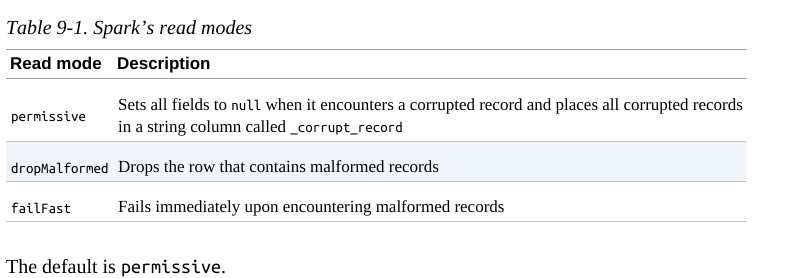

**Basics of Writing Data**

 dataframe.write.format("csv")
 *  .option("mode", "OVERWRITE")
 *  .option("dateFormat", "yyyy-MM-dd")
 *  .option("path", "path/to/file(s)")
 *  .save()

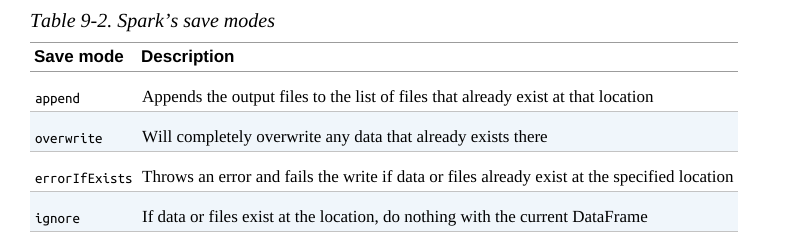

#CSV

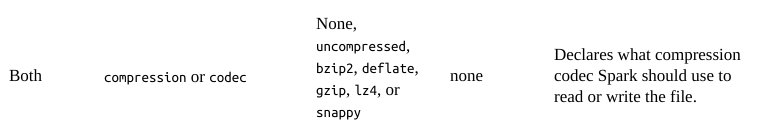

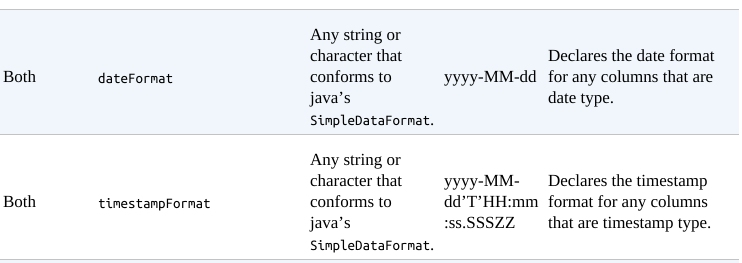

**Reading csv files**

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, LongType
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("FlightDataExample").getOrCreate()

# Define the schema
my_manual_schema = StructType([
    StructField("DEST_COUNTRY_NAME", StringType(), True),
    StructField("ORIGIN_COUNTRY_NAME", StringType(), True),
    StructField("count", LongType(), False)
])

# Read the CSV file with the defined schema
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("mode", "FAILFAST") \
    .schema(my_manual_schema) \
    .load("/data/flight-data/csv/2010-summary.csv")

# Show the first 5 rows
df.show(5)

**Writing CSV Files**

In [ ]:
csvFile.write.format("csv").mode("overwrite").option("sep", "\t")\
 .save("/tmp/my-tsv-file.tsv")

#JSON Files

In [ ]:
#Reading JSON Files
spark.read.format("json").option("mode", "FAILFAST")\
.option("inferSchema", "true")\
.load("/data/flight-data/json/2010-summary.json").show(5)


In [ ]:
#Writing JSON Files
csvFile.write.format("json").mode("overwrite").save("/tmp/my-json-file.json")

#Parquet Files

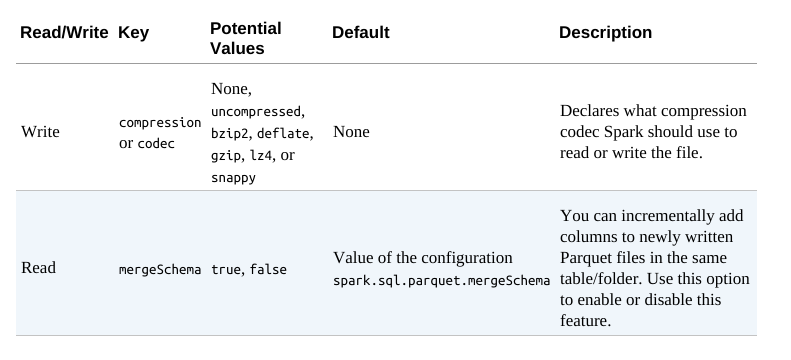

In [ ]:
# Reading Parquet Files
spark.read.format("parquet")\
.load("/data/flight-data/parquet/2010-summary.parquet").show(5)

In [ ]:
#Writing Parquet Files
csvFile.write.format("parquet").mode("overwrite")\
.save("/tmp/my-parquet-file.parquet")

#Text Files

In [ ]:
# Reading Text Files
spark.read.textFile("/data/flight-data/csv/2010-summary.csv")
 .selectExpr("split(value, ',') as rows").show()


In [ ]:
#Writing Text Files
 csvFile.limit(10).select("DEST_COUNTRY_NAME", "count")\
 .write.partitionBy("count").text("/tmp/five-csv-files2py.csv")

If we set an option for a writer as df.write.option("maxRecordsPerFile", 5000), Spark will ensure that files will contain at most 5,000 records.

#

 **Reading Data in Parallel**

 Multiple executors cannot read from the same file at the same time necessarily, but they can read different files at the same time. In general, this means that when you read from a folder with multiple files in it, each one of those files will become a partition in your DataFrame and be read
 in by available executors in parallel (with the remaining queueing up behind the others).

 **Writing Data in Parallel**

The number of files or data written is dependent on the number of partitions the DataFrame has at the time you write out the data.

By default, one file is written per partition of the data

csvFile.repartition(5).write.format("csv").save("/tmp/multiple.csv")

 will end up with five files inside of that folder. As you can see from the

 list call:
 *  ls /tmp/multiple.csv
 *  /tmp/multiple.csv/part-00000-767df509-ec97-4740-8e15-4e173d365a8b.csv
 *  /tmp/multiple.csv/part-00001-767df509-ec97-4740-8e15-4e173d365a8b.csv
 *  /tmp/multiple.csv/part-00002-767df509-ec97-4740-8e15-4e173d365a8b.csv
 *  /tmp/multiple.csv/part-00003-767df509-ec97-4740-8e15-4e173d365a8b.csv
 *  /tmp/multiple.csv/part-00004-767df509-ec97-4740-8e15-4e173d365a8b.csv

# Partitioning

Partitioning in Spark refers to how data is divided into chunks (partitions) that can be processed in parallel across a cluster. Each partition is a logical unit of data that is processed by a single task on a single executor

Think of a partition like a slice of your dataset. If your dataset has 100 partitions and your cluster has 10 cores, Spark can theoretically process 10 partitions in parallel.

**Partitioning is key to performance** because:

It affects parallelism (how many tasks can run at once).

It affects data locality (where data is stored relative to computation).

It affects shuffle operations (moving data between nodes in transformations like joins or aggregations)

**Why Partitioning Matters**

Performance & Parallelism:
*  More partitions → more tasks → more parallelism (up to cluster limits).
*  Fewer partitions → tasks are bigger → can cause memory pressure or slow tasks.

Shuffle Optimization:
*  Certain operations like groupBy, join, or reduceByKey require shuffling data across nodes.
*  Good partitioning can reduce shuffle overhead.

Data Skew Handling:
*  Uneven partitions (some very large, some very small) → some tasks take much longer → slower jobs.

Persistence & Storage:
*  When saving data (e.g., Parquet, ORC), partitioning can control physical layout to speed up queries.

**Types of Partitioning**

Spark mainly uses three types:
1.  Hash Partitioning (Default for Key-Based Operations)

Spark calculates a hash value of the key and assigns it to a partition.
Keys with the same hash always go to the same partition.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CSV_Read").getOrCreate()

rdd = spark.sparkContext.parallelize([("A", 1), ("B", 2), ("A", 3), ("C", 4)])
rdd2 = rdd.partitionBy(2)  # Hash partitioning into 2 partitions

In [ ]:
print(rdd2.getNumPartitions())

2


2. Range Partitioning

Spark assigns data to partitions based on ranges of values, rather than hashes

In [ ]:
rdd = spark.sparkContext.parallelize([(1, "A"), (5, "B"), (10, "C"), (7, "D")])
rdd2 = rdd.sortByKey(numPartitions=3)  # Range partitioning

In [ ]:
print(rdd2.getNumPartitions())

3


Partition 1: keys 1–3

Partition 2: keys 4–7

Partition 3: keys 8–10

3. Custom Partitioning

You define your own logic to assign keys to partitions

In [ ]:
from pyspark.rdd import Partitioner

class MyPartitioner(Partitioner):
    def __init__(self, num_partitions):
        self.numPartitions = num_partitions

    def numPartitions(self):
        return self.numPartitions

    def getPartition(self, key):
        return 0 if key < 5 else 1  # Custom logic

rdd2 = rdd.partitionBy(2, MyPartitioner(2))

In [ ]:
print(rdd2.getNumPartitions())

2


**Repartitioning & Coalescing (Changing Partitions Dynamically)**

Repartition:

*  Increase or decrease partitions.

*  Triggers shuffle, redistributes data evenly.

df_repart = df.repartition(10)  # 10 partitions

Coalesce

decreases partitions (less expensive, avoids full shuffle).

df_coalesced = df.coalesce(2)  # 2 partitions

Note :

*  Hash partitioning scatters keys randomly
*  Range partitioning groups nearby keys together

 # Bucketing

 Bucketing is another file organization approach with which we can control the data that is specifically written to each file.

This can help avoid shuffles later when you go to read the data
because data with the same bucket ID will all be grouped together into one physical partition.


Bucketing is a physical data organization technique where Spark:

*  Hashes a column
*  Divides the data into a fixed number of buckets
*  Writes each bucket as separate files on disk

Note : Bucketing happens when data is written, not during runtime transformations

Problem without Bucketing

When you do a join or groupBy, Spark usually performs a shuffle:

Data moves across executors

Network + disk IO is expensive

Large joins become slow